In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras.backend as K

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.layers.merge import concatenate
import keras.losses

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import ks_2samp

os.chdir('../src/')
import ml_analysis_plotting

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

The cell below accesses and orients the input arrays correctly

In [2]:
def  get_input_arrays(tree, features_list):
    array = np.transpose(tree.arrays(features_list, outputtype=tuple))
    print(array.shape)
    print(array[0])
    return array

In [3]:
os.chdir('../data')

In [4]:
tree = uproot.open('3files.root')[b'features;1']
tree.keys()

[b'top_pt',
 b'top_eta',
 b'top_phi',
 b'tbar_pt',
 b'tbar_eta',
 b'tbar_phi',
 b'lep_t_pt',
 b'lep_t_eta',
 b'lep_t_phi',
 b'lep_tbar_pt',
 b'lep_tbar_eta',
 b'lep_tbar_phi',
 b'nu_top_pt',
 b'nu_top_eta',
 b'nu_top_phi',
 b'nu_tbar_pt',
 b'nu_tbar_eta',
 b'nu_tbar_phi',
 b'b1_pt',
 b'b1_eta',
 b'b1_phi',
 b'b2_pt',
 b'b2_eta',
 b'b2_phi',
 b'ttbar_pt',
 b'ttbar_eta',
 b'ttbar_phi',
 b'top_m',
 b'tbar_m',
 b'lep_top_m',
 b'lep_tbar_m',
 b'nu_top_m',
 b'nu_tbar_m',
 b'b1_m',
 b'b2_m',
 b'ttbar_m',
 b'met',
 b'met_x',
 b'met_y',
 b'c_nn',
 b'c_rr',
 b'c_kk',
 b'c_rk',
 b'c_kr',
 b'c_nr',
 b'c_rn',
 b'c_nk',
 b'c_kn',
 b'c_nk_p_kn',
 b'c_nr_p_rn',
 b'c_rk_p_kr',
 b'c_nk_m_kn',
 b'c_nr_m_rn',
 b'c_rk_m_kr',
 b'b_kplus',
 b'b_nplus',
 b'b_rplus',
 b'b_kminus',
 b'b_nminus',
 b'b_rminus',
 b'lep_delta_phi',
 b'lep_delta_eta',
 b'top_delta_phi',
 b'top_delta_eta',
 b'reco_met',
 b'reco_met_phi',
 b'reco_top_pt',
 b'reco_top_eta',
 b'reco_top_phi',
 b'reco_tbar_pt',
 b'reco_tbar_eta',
 b'reco

In [5]:
## all essential (truth) info
#features_list = [
#b'top_eta',
#b'top_phi',
#b'top_pt',
#b'tbar_eta',
#b'tbar_phi',
#b'tbar_pt',
#b'lep_t_pt',
#b'lep_t_eta',
#b'lep_t_phi',
#b'lep_tbar_pt',
#b'lep_tbar_eta',
#b'lep_tbar_phi',
#]

## all essential (truth) info + some bits that got good results
#features_list = [
#b'top_eta',
#b'top_phi',
#b'top_pt',
#b'tbar_eta',
#b'tbar_phi',
#b'tbar_pt',
#b'lep_t_pt',
#b'lep_t_eta',
#b'lep_t_phi',
#b'lep_tbar_pt',
#b'lep_tbar_eta',
#b'lep_tbar_phi',
#b'lep_delta_phi',
#b'lep_delta_eta',
#b'top_delta_phi',
#b'top_delta_eta',
#]

## the (truth) info we can actually get at with ATLAS (for use with b_kplus)
#features_list = [
#b'lep_t_pt',
#b'lep_t_eta',
#b'lep_t_phi',
#b'lep_delta_phi',
#b'lep_delta_eta',
#b'met_x',
#b'met_y',
#b'b1_pt',
#b'b1_eta',
#b'b1_phi',
#b'b2_pt',
#b'b2_eta',
#b'b2_phi'
#]


## the (truth) info we can actually get at with ATLAS (for use with b_kminus)
#features_list = [
#b'lep_tbar_pt',
#b'lep_tbar_eta',
#b'lep_tbar_phi',
#b'lep_delta_phi',
#b'lep_delta_eta',
#b'met_x',
#b'met_y',
#b'b1_pt',
#b'b1_eta',
#b'b1_phi',
#b'b2_pt',
#b'b2_eta',
#b'b2_phi'
#]


## truth versions of the info we can actually get from ATLAS
features_list = [
b'lep_t_pt',
b'lep_t_eta',
b'lep_t_phi',
b'lep_tbar_pt',
b'lep_tbar_eta',
b'lep_tbar_phi',
b'lep_delta_phi',
b'lep_delta_eta',
b'met_x',
b'met_y',
b'b1_pt',
b'b1_eta',
b'b1_phi',
b'b2_pt',
b'b2_eta',
b'b2_phi'
]

## ATLAS simulation reconstructed stuff (including tops from the 'Neutrino Weighter' algorithm which
## takes reco leptons, b jets and met as its input)
#features_list = [
#b'reco_top_pt',
#b'reco_top_eta',
#b'reco_top_phi',
#b'reco_t_m',
#b'reco_tbar_pt',
#b'reco_tbar_eta',
#b'reco_tbar_phi',
#b'reco_tbar_m',
#b'reco_lep_1_pt',
#b'reco_lep_1_eta',
#b'reco_lep_1_phi',
#b'reco_lep_1_e',
#b'reco_lep_2_pt',
#b'reco_lep_2_eta',
#b'reco_lep_2_phi',
#b'reco_lep_2_e',
#]


In [6]:
spin_target = tree.array(b'b_kplus')
#spin_target = spin_target[np.where(spin_target <  0.)[0]]
#pt_cut = np.where(spin_target/1000.0 < 300.)[0]
#spin_target = spin_target[pt_cut]
h,b,_=plt.hist(spin_target, bins=25)


In [7]:
NW_weight = tree.array('NW_weight')

(array([ 23692.,   6077.,   4737.,   4554.,   4489.,   4638.,   5365.,
          6905.,  11527., 378438.]),
 array([1.00004002e-06, 1.00000900e-01, 2.00000800e-01, 3.00000700e-01,
        4.00000600e-01, 5.00000500e-01, 6.00000400e-01, 7.00000300e-01,
        8.00000200e-01, 9.00000100e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

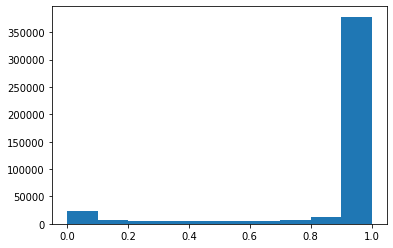

In [8]:
plt.hist(NW_weight)

In [9]:
above5 = np.zeros((len(np.where(NW_weight > 0.5)[0])))
below5 = np.ones((len(np.where(NW_weight < 0.5)[0])))
print(above5.shape)
print(below5.shape)

(406873,)
(43549,)


In [10]:
labels = np.concatenate((above5, below5))

In [11]:
np.where(spin_target ==  -10.)[0]

array([], dtype=int64)

In [12]:
"""
for feature in features_list:
    print(feature)
    #plt.hist(tree1.array(feature),bins=40,density=True,alpha=.8)
    plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)
    plt.show()
"""    

'\nfor feature in features_list:\n    print(feature)\n    #plt.hist(tree1.array(feature),bins=40,density=True,alpha=.8)\n    plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)\n    plt.show()\n'

In [13]:
spin_weights = 1/(h * 1/np.max(h))
print(spin_weights)
locs = np.digitize(spin_target, b)
weights_array = np.zeros(len(spin_target))
for i in range(len(spin_weights)):
    weights_array[np.where(locs == i+1)[0]] = spin_weights[i]
#plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)
#plt.show()

[4.32394949 2.56275304 1.79705781 1.48033449 1.31501416 1.19474949
 1.12736791 1.0885357  1.05345706 1.02021978 1.01162284 1.00835103
 1.01132898 1.         1.01550802 1.02663783 1.03369952 1.02901478
 1.04554783 1.04601903 1.06543915 1.08819546 1.08126715 1.10278746
 1.1013339 ]


(array([20889.       , 20889.       , 20889.       , 20889.       ,
        20889.       , 20889.       , 20889.       , 20889.       ,
        20889.       , 20889.       , 20889.       , 20889.       ,
        20889.       , 20889.       , 20889.       , 20889.       ,
        20889.       , 20889.       , 20889.       , 20889.       ,
        20889.       , 20889.       , 20889.       , 20889.       ,
        20887.8986661]),
 array([-0.99998316, -0.91998394, -0.83998472, -0.75998549, -0.67998627,
        -0.59998705, -0.51998783, -0.43998861, -0.35998939, -0.27999016,
        -0.19999094, -0.11999172, -0.0399925 ,  0.04000672,  0.12000594,
         0.20000517,  0.28000439,  0.36000361,  0.44000283,  0.52000205,
         0.60000127,  0.6800005 ,  0.75999972,  0.83999894,  0.91999816,
         0.99999738]),
 <a list of 25 Patch objects>)

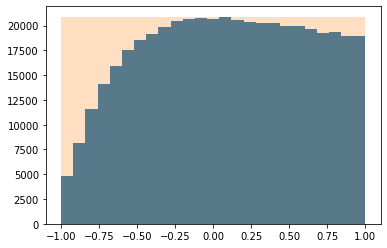

In [14]:
plt.hist(spin_target,bins=25)
plt.hist(spin_target,bins=25,weights=weights_array,alpha=.25)

### This scales the target in order for the ML to be successful

In [15]:
spin_transformer = RobustScaler()
spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
print(spin_target_scaled.shape)

(450422, 1)


In [16]:
features_array = get_input_arrays(tree, features_list)
#features_array = features_array[np.where(spin_target < 0)[0]]



(450422, 16)
[ 4.20560938e+04 -7.84886003e-01 -2.59616232e+00  8.59698281e+04
 -1.89798307e+00 -8.16491306e-01  1.77967101e+00  1.11309707e+00
  4.25833660e+03  2.27110500e+04  1.25139484e+05 -1.92983329e+00
  2.17935160e-01  3.45034058e+03 -4.70294094e+00  1.80621266e+00]


In [17]:
print(spin_target[:10])
print(weights_array[:10])

[ 0.13273674  0.70614278  0.87365312 -0.77303831  0.31663449  0.28299694
 -0.03734384 -0.68224303 -0.69530815  0.48653016]
[1.01550802 1.08819546 1.10278746 1.79705781 1.03369952 1.03369952
 1.01132898 1.48033449 1.48033449 1.04554783]


In [18]:
np.where(np.isnan(features_array) == True)

(array([], dtype=int64), array([], dtype=int64))

In [19]:
transformer = RobustScaler()
features_array_scaled = transformer.fit_transform(features_array)
print(features_array_scaled.shape)

(450422, 16)


In [21]:
modname = "test_models_01"

## test_models_01_01
#modname = modname + '_01'
#model = Sequential()
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

## test_models_01_02
#model = Sequential()
#modname = modname + '_02'
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

## test_models_01_03
#model = Sequential()
#modname = modname + '_03'
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

## test_models_01_04
#model = Sequential()
#modname = modname + '_04'
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(25, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

## test_models_01_05
#model = Sequential()
#modname = modname + '_05'
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(25, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

## test_models_01_06
#model = Sequential()
#modname = modname + '_06'
#model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(25, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))## test_models_01_06

## test_models_01_07
model = Sequential()
modname = modname + '_07'
model.add(Dense(200, input_dim=len(features_list), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
#model = multihead_model(features_list)

In [23]:
def custom_loss(y_true, y_pred):
    
    return ((K.abs(y_pred) * 1.0) * keras.losses.logcosh(y_pred, y_true))
    #return (keras.losses.logcosh(y_pred, y_true))
def custom_loss_2(y_true, y_pred):
    
    return (y_true - y_pred)
    #return (keras.losses.logcosh(y_pred, y_true))

In [24]:
#model.compile(loss='logcosh', optimizer='adam', metrics=['mae', 'mse'])
model.compile(loss=[custom_loss], optimizer='adam', metrics=['mae', 'mse',custom_loss_2])
#model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [25]:
features_array_scaled, spin_target_scaled, weights_array = shuffle(features_array_scaled, spin_target_scaled, weights_array)
#selection1 = np.random.choice(np.where(labels == 0)[0],len(below5),replace=False)
#selection2 = np.where(labels == 1)[0]
#selection = np.concatenate((selection1,selection2))
#features_array_scaled, labels, weights_array = shuffle(features_array_scaled[selection], labels[selection], weights_array[selection])

In [26]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features_array_scaled, spin_target_scaled, weights_array, test_size=0.2)
#X_train, X_test, y_train1, y_test1, y_train2, y_test2, w_train, w_test = test_train_split(features, targets1, targets2, weights)
#X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features_array_scaled, labels, weights_array, test_size=0.2)

In [27]:
print(spin_target_scaled[:10])
print(w_train[:10])

[[0.24418855]
 [0.74724834]
 [0.98409028]
 [0.57386611]
 [0.03503256]
 [0.58619758]
 [0.84338593]
 [0.83428521]
 [0.88981683]
 [0.30725958]]
[1.02663783 1.48033449 1.04601903 1.03369952 1.12736791 1.03369952
 1.08819546 1.79705781 1.06543915 2.56275304]


In [28]:
es = EarlyStopping(monitor='val_loss')


## If you don't redefine/compile/build the model, the weights are 'updated' from the previous training

In [29]:
#history = model.fit(X_train, y_train, epochs=600, batch_size=256, verbose=1, validation_split=.2, sample_weight=w_train)
#history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_split=.2, callbacks=[es])
history = model.fit(X_train, y_train, epochs=150, batch_size=256, verbose=1, validation_split=.2)
print("done!")


Train on 288269 samples, validate on 72068 samples
Epoch 1/150
288269/288269 [==============================] - 6s 21us/step - loss: 0.0106 - mae: 0.1678 - mse: 0.0438 - custom_loss_2: 0.0462 - val_loss: 0.0086 - val_mae: 0.1510 - val_mse: 0.0349 - val_custom_loss_2: 0.0435
Epoch 2/150
288269/288269 [==============================] - 5s 19us/step - loss: 0.0085 - mae: 0.1466 - mse: 0.0340 - custom_loss_2: 0.0346 - val_loss: 0.0069 - val_mae: 0.1346 - val_mse: 0.0291 - val_custom_loss_2: 0.0607
Epoch 3/150
288269/288269 [==============================] - 6s 19us/step - loss: 0.0071 - mae: 0.1322 - mse: 0.0281 - custom_loss_2: 0.0282 - val_loss: 0.0058 - val_mae: 0.1209 - val_mse: 0.0238 - val_custom_loss_2: 0.0478
Epoch 4/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0065 - mae: 0.1254 - mse: 0.0254 - custom_loss_2: 0.0252 - val_loss: 0.0055 - val_mae: 0.1164 - val_mse: 0.0222 - val_custom_loss_2: 0.0436
Epoch 5/150
288269/288269 [=========================

288269/288269 [==============================] - 6s 19us/step - loss: 0.0054 - mae: 0.1133 - mse: 0.0211 - custom_loss_2: 0.0208 - val_loss: 0.0049 - val_mae: 0.1100 - val_mse: 0.0193 - val_custom_loss_2: 0.0241
Epoch 37/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0054 - mae: 0.1133 - mse: 0.0211 - custom_loss_2: 0.0208 - val_loss: 0.0049 - val_mae: 0.1100 - val_mse: 0.0192 - val_custom_loss_2: 0.0245
Epoch 38/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0054 - mae: 0.1129 - mse: 0.0210 - custom_loss_2: 0.0205 - val_loss: 0.0050 - val_mae: 0.1110 - val_mse: 0.0192 - val_custom_loss_2: 0.0191
Epoch 39/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0054 - mae: 0.1127 - mse: 0.0210 - custom_loss_2: 0.0205 - val_loss: 0.0051 - val_mae: 0.1136 - val_mse: 0.0200 - val_custom_loss_2: 0.0229
Epoch 40/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0054 - mae: 0.1128 - mse: 0.

288269/288269 [==============================] - 6s 20us/step - loss: 0.0053 - mae: 0.1115 - mse: 0.0206 - custom_loss_2: 0.0200 - val_loss: 0.0050 - val_mae: 0.1113 - val_mse: 0.0194 - val_custom_loss_2: 0.0240
Epoch 73/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0053 - mae: 0.1116 - mse: 0.0206 - custom_loss_2: 0.0203 - val_loss: 0.0048 - val_mae: 0.1089 - val_mse: 0.0187 - val_custom_loss_2: 0.0172
Epoch 74/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0053 - mae: 0.1114 - mse: 0.0205 - custom_loss_2: 0.0201 - val_loss: 0.0048 - val_mae: 0.1084 - val_mse: 0.0184 - val_custom_loss_2: 0.0143
Epoch 75/150
288269/288269 [==============================] - 6s 19us/step - loss: 0.0053 - mae: 0.1113 - mse: 0.0205 - custom_loss_2: 0.0199 - val_loss: 0.0048 - val_mae: 0.1086 - val_mse: 0.0186 - val_custom_loss_2: 0.0178
Epoch 76/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0053 - mae: 0.1114 - mse: 0.

288269/288269 [==============================] - 6s 19us/step - loss: 0.0052 - mae: 0.1106 - mse: 0.0203 - custom_loss_2: 0.0198 - val_loss: 0.0047 - val_mae: 0.1066 - val_mse: 0.0182 - val_custom_loss_2: 0.0176
Epoch 109/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0053 - mae: 0.1110 - mse: 0.0204 - custom_loss_2: 0.0200 - val_loss: 0.0049 - val_mae: 0.1096 - val_mse: 0.0188 - val_custom_loss_2: 0.0194
Epoch 110/150
288269/288269 [==============================] - 6s 22us/step - loss: 0.0052 - mae: 0.1106 - mse: 0.0203 - custom_loss_2: 0.0198 - val_loss: 0.0050 - val_mae: 0.1112 - val_mse: 0.0190 - val_custom_loss_2: 0.0141
Epoch 111/150
288269/288269 [==============================] - 6s 21us/step - loss: 0.0052 - mae: 0.1105 - mse: 0.0203 - custom_loss_2: 0.0197 - val_loss: 0.0049 - val_mae: 0.1110 - val_mse: 0.0192 - val_custom_loss_2: 0.0206
Epoch 112/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1107 - mse

288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1102 - mse: 0.0201 - custom_loss_2: 0.0197 - val_loss: 0.0048 - val_mae: 0.1087 - val_mse: 0.0185 - val_custom_loss_2: 0.0169
Epoch 145/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1103 - mse: 0.0201 - custom_loss_2: 0.0196 - val_loss: 0.0049 - val_mae: 0.1107 - val_mse: 0.0188 - val_custom_loss_2: 0.0132
Epoch 146/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1102 - mse: 0.0201 - custom_loss_2: 0.0196 - val_loss: 0.0049 - val_mae: 0.1107 - val_mse: 0.0188 - val_custom_loss_2: 0.0127
Epoch 147/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1101 - mse: 0.0201 - custom_loss_2: 0.0196 - val_loss: 0.0048 - val_mae: 0.1082 - val_mse: 0.0184 - val_custom_loss_2: 0.0184
Epoch 148/150
288269/288269 [==============================] - 6s 20us/step - loss: 0.0052 - mae: 0.1104 - mse

In [31]:
model.save_weights('model_weights.h5')

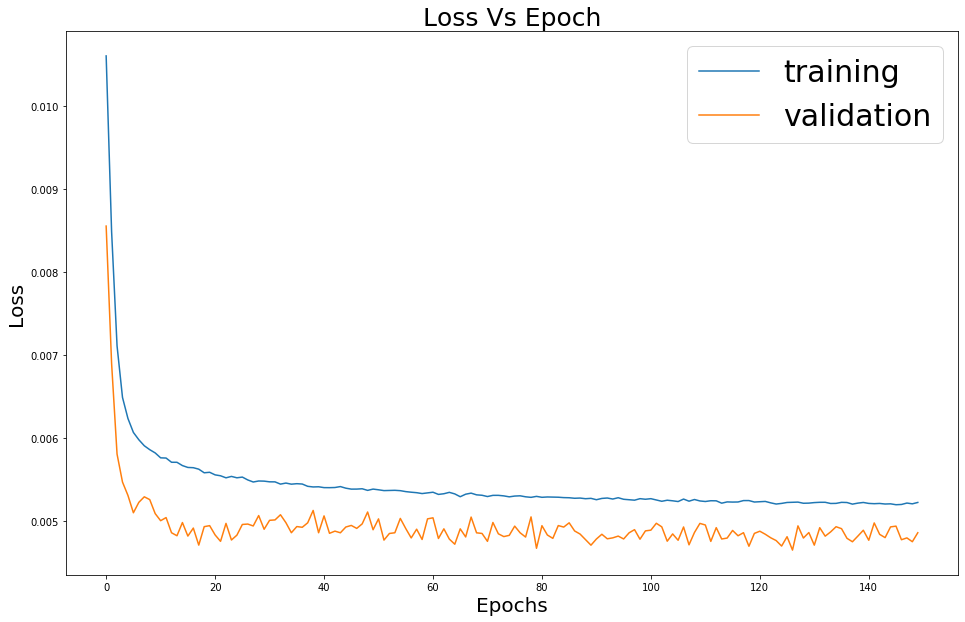

In [32]:
fig, ax = plt.subplots(figsize=(16, 10))
'''
for i in range(1):
    plt.scatter(range(len(histories[i])), histories[i])
'''
#history_hist = plt.hist(history.history['loss'], bins=50)
#plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training w. deltas')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
#plt.plot(range(len(history.history['val_mae'])), history.history['val_mae'], label='validation2')
plt.legend(fontsize=30)
plt.xlabel('Epochs', fontsize=20)
#plt.ylabel('Mean absolute error', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss Vs Epoch', fontsize=25)
plt.savefig(modname+'_loss')
plt.show()

In [33]:
y_pred = model.predict(X_test)
print(model.evaluate(X_test, y_test))

90085/90085 [==============================] - 2s 21us/step
[0.004875269621619325, 0.10919246822595596, 0.01868428662419319, 0.01758679561316967]


In [34]:
#plt.hist(y_pred)
#plt.hist(y_test)

In [35]:
#spin_transformer = RobustScaler()
#spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
#spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
#print(spin_target_scaled.shape)

#transformer = RobustScaler()
#features_array_scaled = transformer.fit_transform(features_array)
#print(features_array_scaled.shape)

In [36]:
y_pred_unscaled = y_pred*2 - 1
y_test_unscaled = y_test*2 - 1
#y_pred_unscaled = y_pred - 1
#y_test_unscaled = y_test - 1

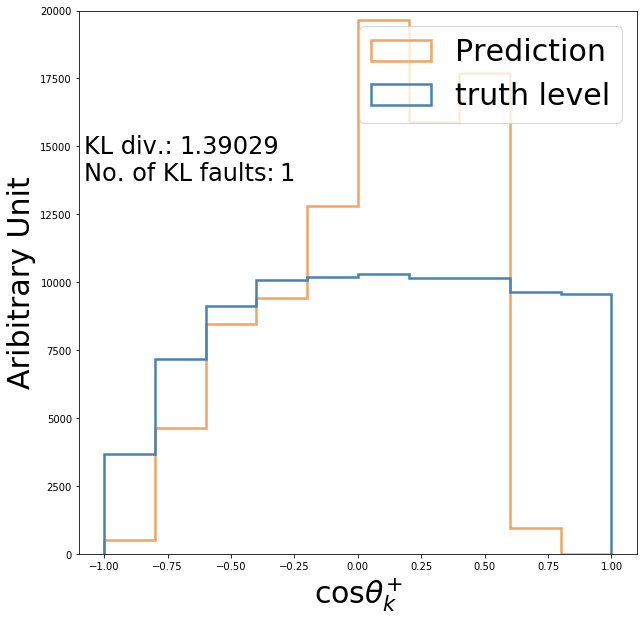

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
a = y_pred_unscaled
b = y_test_unscaled
bins=np.histogram(np.hstack((a,b)), bins=10)[1]
h1,b1,_=plt.hist(a, bins, histtype='step', linewidth=2.5, label='Prediction', color='sandybrown')
h2,b2,_=plt.hist(b, bins, histtype='step', linewidth=2.5, label='truth level', color='steelblue')
KLdiv = 0.0
KLfault = False
KLfault_n = 0
for i in range(len(h1)):
    #print("bin", i, h2[i]/tot_h)
    truth_prob = h2[i]/np.sum(h2)
    #print(val/len(a), ent)
    pred_prob = h1[i]/np.sum(h1)
    #pred_prob = 0.0
    if pred_prob == 0.0:
        KLfault = True
        KLfault_n += 1
        pred_prob = 0.000001
    if truth_prob == 0.0:
        truth_prob = 0.000001
    KLdiv += truth_prob*(np.log(truth_prob) - np.log(pred_prob))
        #print(KLdiv)
        #KLdiv += (np.log(truth_prob) - np.log(pred_prob))
plt.text(0.01, 0.75,'KL div.:', fontsize=24, verticalalignment='center', transform=ax.transAxes)
plt.text(0.18, 0.75,round(KLdiv,5), fontsize=24, verticalalignment='center', transform=ax.transAxes)
if KLfault:
    plt.text(0.01, 0.7,'No. of KL faults:',fontsize=24, verticalalignment='center', transform=ax.transAxes)
    plt.text(0.36, 0.7, KLfault_n, fontsize=24, verticalalignment='center', transform=ax.transAxes)
plt.legend(fontsize=30)
plt.ylim(0,20000)
plt.xlabel(r'cos$\theta_{k}^{+}$', fontsize=30)
plt.ylabel('Aribitrary Unit', fontsize=30)
plt.savefig(modname+'_pred')
plt.show()

In [71]:
y_diff = y_test_unscaled - y_pred_unscaled
y_diff = y_diff[np.logical_not(np.isnan(y_diff))]
print(np.std((y_test_unscaled - y_pred_unscaled)))

0.27110858413187183


In [72]:
fig, ax = plt.subplots(figsize=(20,10))
#plt.bar(range(len(h1)),h1/len(a),alpha=.4, color='sandybrown', label='Prediction from truth w deltas')
plt.bar(range(len(h1)),h1/len(a),alpha=.4, color='sandybrown', label='Prediction')
plt.bar(range(len(h2)),h2/len(b),alpha=.5, color='steelblue', label='truth level')
plt.legend(fontsize=30)
plt.xlabel(r'(bins of) cos$\theta_{k}^{+}$cos$\theta_{k}^{-}$', fontsize=30)
plt.ylabel('Probability', fontsize=30)

#plt.annotate("Kullback-Leibler divergence:", (.3,.94))
#plt.annotate("Kullback-Leibler divergence:", (.3,.94), fontsize=24)
#fig = plt.figure()
#text='''testt'''
#fig.text(.1,.1,text)
plt.text(0.14, 0.75,'KL div. = ', ha='right', va='center', transform=ax.transAxes, fontsize=24)
plt.text(0.15, 0.75,round(KLdiv,5), ha='left', va='center', transform=ax.transAxes, fontsize=24)

#plt.text(0.2, 0.8,'epochs = ', ha='right', va='center', transform=ax.transAxes, fontsize=24)
#plt.text(0.211, 0.8,'600', ha='left', va='center', transform=ax.transAxes, fontsize=24)

plt.savefig(modname + '_prob')
plt.show()
#print(h1/len(a))

## KL divergence ##
#KLdiv = 0.0
#for i in range(len(h1)):
#    truth_prob = h[i]/tot_h
#    #print(val/len(a), ent)
#    pred_prob = h1[i]/len(a)
#    if pred_prob > 0.0 and truth_prob > 0.0:
#        KLdiv += truth_prob*(np.log(truth_prob) - np.log(pred_prob))
#print(KLdiv)



In [73]:
class make_hist_dicts:

    def correct_compare_hist(self,
        array1, array2, nBins=40, normed=False, gauss=False, logY=False
    ):
        array1_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}
        array2_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}

        array1 = self.removeNan(array1)
        array2 = self.removeNan(array2)

        if gauss is True:
            ratio = guassian_comparison_ratio(array1, array2, nBins)
        else:
            ratio = np.ones(nBins)
        
        hist1, bins1, hist2, bins2 = self.get_hists(array2, array1, nBins)
        
        stat = np.round(ks_2samp(plt.hist(array1, bins=nBins)[0], plt.hist(array2, bins=nBins)[0]), 4)
        plt.close()
        b1 = np.zeros(len(hist1))
        w1 = np.zeros(len(hist1))
        for i in range(len(hist1)):
            b1[i] = (bins1[i + 1] + bins1[i]) / 2
            w1[i] = bins1[i + 1] - bins1[i]
        b2 = b1
        w2 = w1
        
        array1_dict["binDx"] = w1
        array2_dict["binDx"] = w2
        
        array1_dict["hist"] = hist1
        array2_dict["hist"] = hist2
        
        array1_dict["binx"] = b1
        array2_dict["binx"] = b2
        
        hist1 = np.multiply(hist1, ratio)
        hist2 = np.multiply(hist2, ratio)

        weights1 = self.get_weights(array1, bins1, ratio)
        weights2 = self.get_weights(array2, bins2, ratio)
        
        array1_dict["weights"] = weights1
        array2_dict["weights"] = weights2

        if normed is False:
            scale1 = np.maximum(np.max(hist1), np.max(hist2))
            scale2 = scale1
        else:
            scale1 = np.max(hist1)
            scale2 = np.max(hist2)
        
        #error = hist2/len(array2)
        error = 1./hist2    
        fig, ax = plt.subplots(figsize=(16, 10))
        plt.cla()
        if logY is True:
            ax.set_yscale("log")
        ax.set_title("Regression Analysis - model 3, Batches", fontsize=35)
        ax.set_xlabel("kk", fontsize=24)
        ax.set_ylabel("Arbitraty Units", fontsize=24)
        plt.bar(b1, hist1 / scale1, width=w1, alpha=0.2, color="blue", label="Truth")
        plt.bar(b2, hist2 / scale2, width=w2, yerr=error, alpha=0.2, color="red", label="Prediction")
        plt.bar(
            b1,
            hist1 / scale1,
            width=w1,
            alpha=1.0,
            color="none",
            edgecolor="blue",
            linewidth=2.0,
        )
        plt.bar(
            b2,
            hist2 / scale2,
            width=w2,
            alpha=1.0,
            color="none",
            edgecolor="red",
            linewidth=2.0,
        )
        plt.annotate("Kolmogorov–Smirnov", (.7,.94), fontsize=24)
        plt.annotate("Statistic: "+str(stat[0]), (.75,.87), fontsize=24)
        plt.annotate("P-value: "+str(stat[1]), (.75,.80), fontsize=24)
        plt.legend(fontsize=24)
        plt.ylim(0,1.2)
        plt.show()
        
        return array1_dict, array2_dict, ratio

    def removeNan(self,array):
        if len(np.where(np.isnan(array) is True)) == 0:
            pass
        return array[np.logical_not(np.isnan(array))]

    def get_hists(self, array1, array2, nBins):

        """
        array1 = (
            2 * (array1 - np.min(array1)) / (np.max(array1) - np.min(array1)) - 1
        )
        array2 = (
            2 * (array2 - np.min(array2)) / (np.max(array2) - np.min(array2)) - 1
        )
        """

        hist1, bins1, _ = plt.hist(
            array2, color="blue", alpha=0.2, bins=nBins
        )  # , weights=true_z_w)
        plt.close()
        bins2 = bins1
        hist2 = np.zeros(len(hist1))

        # z_reg = np.multiply(test_z_torch.data.numpy().reshape(1000), test_z_w)
        # z_reg = test_z_torch.data.numpy().reshape(len(true_z))
        # z_reg = test_z_torch

        for i in range(len(hist1)):
            hist2[i] = len(
                np.where(array1[np.where((array1 <= bins1[i + 1]))[0]] > bins1[i])[0]
            )  # & (z_reg > bins1[i])[0])]))
            if i == len(hist1):
                hist2[i] = len(np.where(array1 >= bins1[i])[0])
        return hist1, bins1, hist2, bins2

    def get_weights(self, array, bins, ratio):

        weights = np.zeros(len(array))
        bins = np.digitize(array, bins)

        for i in range(len(ratio)):
            weights[np.where(bins == i)] = ratio[i]

        return weights

In [ ]:
y_y = spin_transformer.fit_transform(y_test.reshape(-1,1))
y_y = (y_y - np.min(y_y))/(np.max(y_y) - np.min(y_y))
comp = make_hist_dicts()
hist1, hist2, ratio = comp.correct_compare_hist(y_y, y_pred, nBins=10)